# Example 2: Training the Normalizing Flows

In this example, we will train the Normalizing Flows to predict the number of satellties from the simulation parameters, i.e. the WDM mass and astrophysical parameters. This follows closely the script: `train_flows.py`.

In [1]:
import os
import sys

# replace this with the path to the nehod_torch repository
sys.path.append('/path/to/your/nehod_torch')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import zuko
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from nehod import train_utils

%matplotlib inline

## Step 1: read and preprocess the data

Similarly to the previous example, we will start by reading and preprocessing the data. We will use the `datasets.py` module to read the data and preprocess it.
For this example, the conditioning and target features are:
- Conditioning features: WDM mass and astrophysical parameters $\{m_\mathrm{WDM}, A_\mathrm{SN1}, A_\mathrm{SN2}, A_\mathrm{AGN}\}$
- Target feature: number of satellites $N_\mathrm{sat}$

In practice, we will use the inversed WDM mass and log of the astrophysical parameters, since the distributions are more uniform in these spaces.
The number of satellties $N_\mathrm{sat}$ is discrete, which might not be ideal for the flows. Thus, we will log-transform the number of satellites and use $\log N_\mathrm{sat}$ as the target feature.

In [2]:
# Define the conditioning features and target features of the flows
conditioning_parameters = ['inv_wdm_mass', 'log_sn1','log_sn2','log_agn1']
target_parameters = ['log_num_subhalos', ]
num_target = len(target_parameters)

# Note that `datasets.read_preprocess_dataset` is designed to read both the 
# satellite galaxies and conditioning features, so this is a quick workaround
_, data, _, norm_dict = datasets.read_preprocess_dataset(
    data_root='data', data_name='example', flag=None,
    conditioning_parameters=target_parameters + conditioning_parameters)
target = data[:, :num_target]
cond = data[:, num_target:]

# restructuring the norm_dict
new_norm_dict = {
    'target_mean': norm_dict['cond_mean'][:num_target],
    'target_std': norm_dict['cond_std'][:num_target],
    'cond_mean': norm_dict['cond_mean'][num_target:],
    'cond_std': norm_dict['cond_std'][num_target:],
}

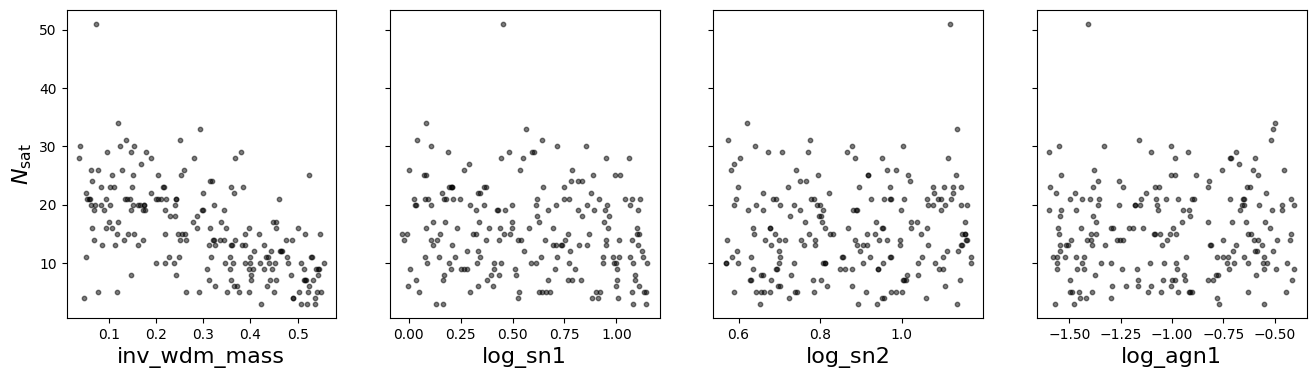

In [3]:
# Plot the data as an example
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

# since the data is normalized, we need to unnormalize it
target_unnorm = target * new_norm_dict['target_std'] + new_norm_dict['target_mean']
cond_unnorm = cond * new_norm_dict['cond_std'] + new_norm_dict['cond_mean']

for i, ax in enumerate(axes):
    ax.scatter(
        cond_unnorm[:, i], 10**target_unnorm, # also unlog the number of subhalos
        alpha=0.5, s=10, color='k')
    ax.set_xlabel(conditioning_parameters[i], fontsize=16)
axes[0].set_ylabel(r'$N_\mathrm{sat}$', fontsize=16)

plt.show()

As expected, we see that the number of satellites decreases with decreasing WDM mass, due to the suppression of small-scale structure. 
Due to the small dataset, it is difficult to discern any trend in  $N_\mathrm{sat}$ with the astrophysical parameters $A_\mathrm{SN1}$, $A_\mathrm{SN2}$, and $A_\mathrm{AGN}$.
Please refer to Figure 3 in the preprint for a clearer visualization of the trends.

We can now convert the data to Pytorch tensors and create a DataLoader. We will also use `datasets.py` to do this. 

In [4]:
data_loader = datasets.create_dataloader(
    (target, cond), batch_size=64,
    shuffle=True, pin_memory=torch.cuda.is_available())

## Step 2: define the model

Now we will define the flow model using the `zuko` library. We will use Neural Spline Flows (NSF), see [Durkan et al 2019](https://arxiv.org/abs/1906.04032).

Similarly, we will use Pytorch Lightning to handle training, and define the training loop, validation loop, and gradient descenr optimizer in the model.

In [5]:
class NPE(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # hyperparameters of the flows as defined in `configs/example_flows.py`
        context_dim = 4
        in_dim = 1
        num_transforms = 4
        projection_dims = [32, 32]
        hidden_dims = [16, 16, 16, 16]
        dropout = 0.1

        self.lin_proj_layers = nn.ModuleList()
        for i in range(len(projection_dims)):
            in_proj_dim = context_dim if i == 0 else projection_dims[i - 1]
            out_proj_dim = projection_dims[i]
            self.lin_proj_layers.append(nn.Linear(in_proj_dim, out_proj_dim))
            self.lin_proj_layers.append(nn.ReLU())
            self.lin_proj_layers.append(nn.BatchNorm1d(out_proj_dim))
            self.lin_proj_layers.append(nn.Dropout(dropout))
        self.lin_proj_layers = nn.Sequential(*self.lin_proj_layers)
        self.flow = zuko.flows.NSF(
            in_dim, projection_dims[-1], transforms=num_transforms,
            hidden_features=hidden_dims, randperm=True
        )

    def forward(self, context):
        embed_context = self.lin_proj_layers(context)
        return embed_context

    def training_step(self, batch, batch_idx):
        target, context = batch
        embed_context = self.forward(context)
        loss = -self.flow(embed_context).log_prob(target).mean()
        self.log('train_loss', loss, on_step=True, on_epoch=True, batch_size=target.size(0))
        return loss

    def validation_step(self, batch, batch_idx):
        target, context = batch
        embed_context = self.forward(context)
        loss = -self.flow(embed_context).log_prob(target).mean()
        self.log('val_loss', loss, on_step=True, on_epoch=True, batch_size=target.size(0))
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(), lr=5e-4, betas=(0.9, 0.999), weight_decay=0.01)
        return optimizer

## Step 3: train the model

The rest of the training syntax is similar to Notebook 1.

In [6]:
pl.seed_everything(53)

# Initialize the model
model = NPE()

# Define callbacks function, including early stopping, model checkpointing, and learning rate monitoring
callbacks = [
    pl.callbacks.EarlyStopping(
        monitor='train_loss', patience=100,  # reminder, this should be val_loss but we don't have a validation set
        mode='min', verbose=True),
    pl.callbacks.ModelCheckpoint(
        filename="{epoch}-{train_loss:.4f}", monitor='train_loss',
        save_top_k=1, mode='min', save_weights_only=False,
        save_last=True),
    pl.callbacks.LearningRateMonitor("step"),
]
# logger to save the training logs, this should work even if you don't have tensorboard installed
# alternatively, you can use pl_loggers.WandbLogger to log the results to Weights & Biases
# or pl_loggers.CSVLogger to save the logs to a CSV file
train_logger = pl_loggers.TensorBoardLogger('output/flows', version='')

# Define a PyTorch Lightning Trainer, which will handle the entire training process
trainer = pl.Trainer(
    default_root_dir='output/flows',
    max_steps=1_000,  # maximum number of training steps   
    accelerator='gpu',  # remove if running on CPU
    callbacks=callbacks,
    logger=train_logger,
    enable_progress_bar=True,
    inference_mode=False,
    val_check_interval=20,
    check_val_every_n_epoch=None,
    log_every_n_steps=10,
)

# train the model
trainer.fit(model, data_loader, ckpt_path=None)

Seed set to 53
/mnt/home/tnguyen/miniconda3/envs/geometric/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mnt/home/tnguyen/miniconda3/envs/geometric/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/mnt/home/tnguyen/miniconda3/envs/geometric/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mnt/home/tnguyen/miniconda3/envs/geometric/lib/pyth ...
/mnt/home/tnguyen/miniconda3/envs/geometric/lib/python3.11/site-packages/pytorch_lightning/trainer/configuratio

Epoch 249: 100%|██████████| 4/4 [00:00<00:00, 23.68it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 249: 100%|██████████| 4/4 [00:00<00:00, 23.07it/s]


## Step 4: generate samples with the flows

Once trained, we can generate new samples using the flows. Instead of using the conditioning features from the  dataset (like in the diffusion case in Example 1), here we can sample the conditioning features from the prior distribution.

In [7]:
pl.seed_everything(54)
n_samples = 1000  # number of samples to generate
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

# Sample new conditioning features (or context) from the prior distribution
context_min = np.array(
    [1/30, np.log10(0.9), np.log10(3.7), np.log10(0.025)])
context_max = np.array(
    [1/1.8, np.log10(14.4), np.log10(14.8), np.log10(0.4)])
context = np.random.uniform(context_min, context_max, size=(n_samples, 4))

# normalized and convert to tensor
context_norm = (context - new_norm_dict['cond_mean']) / new_norm_dict['cond_std']
context_norm = torch.tensor(context_norm, dtype=torch.float32)
context_norm = context_norm.to(model.device)

with torch.no_grad():
    flow_context = model(context_norm)
    samples = model.flow(flow_context).sample()
    samples = samples.cpu().numpy()

# rescale the samples to the original scale
samples = samples * new_norm_dict['target_std'] + new_norm_dict['target_mean']

Seed set to 54


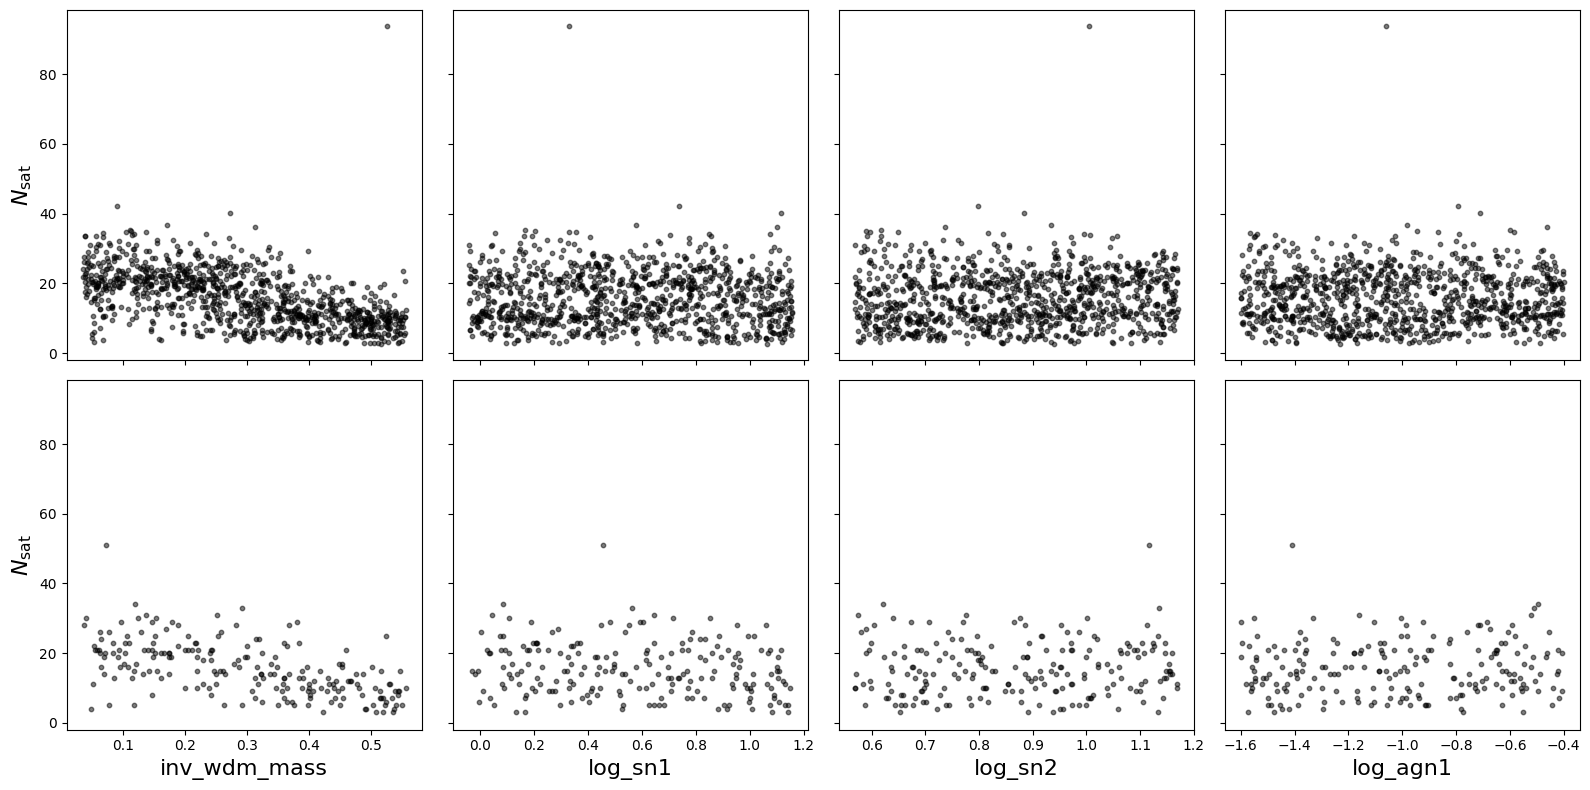

In [8]:
# Plot the generated data
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=True, sharex='col')

for i in range(4):
    axes[0, i].scatter(
        context[:, i], 10**samples,alpha=0.5, s=10, color='k')
    axes[1, i].scatter(
        cond_unnorm[:, i], 10**target_unnorm, alpha=0.5, s=10, color='k')
    axes[-1, i].set_xlabel(conditioning_parameters[i], fontsize=16)
axes[0, 0].set_ylabel(r'$N_\mathrm{sat}$', fontsize=16)
axes[1, 0].set_ylabel(r'$N_\mathrm{sat}$', fontsize=16)
fig.tight_layout()
plt.show()

As mentioned, due to the small published dataset, it is hard to discern any trend in the dataset, with the exception of the WDM mass. It is thus hard to tell if the flows are learning the underlying distribution.

Additionally, sometimes the flows can generate samples that are outside of the distribution. The maximum number of satellites $N_\mathrm{sat}$ is 50, but the flows can generate samples with $N_\mathrm{sat} > 50$. A few notes:
- Similarly to the diffusion model, it is difficult to naturally impose any hard cut-off in the distribution during training, since the flows are trained to approximate smooth distributions.
- However, we can impose a cut-off in the sampling procedure, and discard any samples with $N_\mathrm{sat} > 50$. This is done for samples shown in the preprint. 
- The number of samples that are outside the distribution is small. Out of 1000 generated samples, only 1 sample had $N_\mathrm{sat} > 50$. We see that the flows have predicted a steep drop-off in the distribution of $N_\mathrm{sat}$, which is good. With more training samples, the flows can learn to approximate this steep drop-off better, leading to fewer samples outside the distribution.